In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm import tqdm
from ResUnet import *
import os

f_val = "data/spectralis/hcval/data.pkl"
f_train = "data/spectralis/hctrain/data.pkl"
f_test = "data/spectralis/hceval/data.pkl"

with open(f_val, 'rb') as f:
    data_val = pickle.load(f)

labels_val = data_val['labels']
images_val = data_val['images']
filenames_val = data_val['file_names']


with open(f_train, 'rb') as f:
    data_train = pickle.load(f)

labels_train = data_train['labels']
images_train = data_train['images']
filenames_train = data_train['file_names']

with open(f_test, 'rb') as f:
    data_test = pickle.load(f)

labels_test = data_test['labels']
images_test = data_test['images']
filenames_test = data_test['file_names']


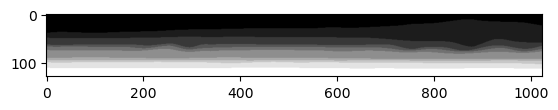

In [2]:
plt.figure()
plt.imshow(labels_train[0], cmap='gray')
plt.show()

In [3]:
## 调整数据size
images_train = images_train[:, np.newaxis, :, :]
images_val = images_val[:, np.newaxis, :, :]
images_test = images_test[:, np.newaxis, :, :]
# labels_train = labels_train[:, np.newaxis, :, :]
# labels_val = labels_val[:, np.newaxis, :, :]
# labels_test = labels_test[:, np.newaxis, :, :]

## 转化为torch tensor
labels_train = torch.tensor(labels_train, dtype=torch.float32)
labels_val = torch.tensor(labels_val, dtype=torch.float32)
images_train = torch.tensor(images_train, dtype=torch.float32)
images_val = torch.tensor(images_val, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)
images_test = torch.tensor(images_test, dtype=torch.float32)


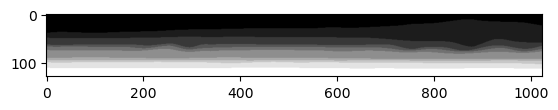

In [4]:
plt.figure()
plt.imshow(labels_train[0], cmap='gray')
plt.show()

In [5]:
# 设置超参数
BATCH_SIZE = 2
EPOCHS = 40
LEARNING_RATE = 1e-2
NUM_CLASSES = 10
EVAL_FREQ = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device("cuda:5")

## label转化为one-hot
print(labels_train.shape)

def to_one_hot(labels):
    one_hot = F.one_hot(labels.to(torch.int64), NUM_CLASSES).permute(0, 3, 1, 2)
    return one_hot.float()



torch.Size([588, 128, 1024])


In [6]:
print(labels_train.shape)
labels_train = to_one_hot(labels_train)
labels_val = to_one_hot(labels_val)
labels_test = to_one_hot(labels_test)

print(labels_train.shape)
print(labels_train[345,:,123,0])

## 创建dataset和加载器
train_dataset = TensorDataset(images_train, labels_train)
val_dataset = TensorDataset(images_val, labels_val)
test_dataset = TensorDataset(images_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)
print(len(train_loader), len(val_loader))

torch.Size([588, 128, 1024])
torch.Size([588, 10, 128, 1024])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
294 74


In [7]:
print(images_train.shape)

torch.Size([588, 1, 128, 1024])


torch.Size([10, 128, 1024])
torch.Size([128, 1024])


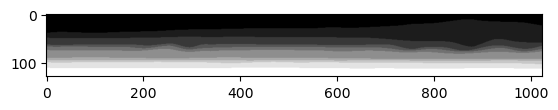

In [8]:
## 检查一下是否转化成功


tmp = labels_train[0]
print(tmp.shape)
tmp = tmp.max(0)[1]
print(tmp.shape)
tmp = tmp.float().numpy()

# 使用 matplotlib 显示图像
plt.figure()
plt.imshow(tmp, cmap='gray')
plt.show()

In [9]:
## 定义训练和验证函数

def train_one_epoch(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(data_loader)

def validate(model, criterion, data_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    return val_loss / len(data_loader)


In [10]:
import logging

logger = logging.getLogger(__name__)

output_dir = "output"
checkpoint_dir = os.path.join(output_dir, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)


model = ResUnet(1, 10).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
losses_train = []
bst_model_num = 0
for epoch in range(EPOCHS):
    logger.info(f'---------Training Epoch: {epoch+1:03d} started---------')
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, DEVICE)
    losses_train.append(train_loss)
    logger.info(f'Train Loss: {train_loss:.4f}')

    val_loss = 0.0
    if (epoch+1) % EVAL_FREQ == 0 or epoch == EPOCHS-1:
        logger.info(f'---------Validation Epoch: {epoch+1:03d} started---------')

        val_loss = validate(model, criterion, val_loader, DEVICE)
        logger.info(f'Validation Loss: {val_loss:.4f}')

        checkpoint_path = os.path.join(checkpoint_dir, f'model_at_epoch_{epoch+1:02d}.pth')
        torch.save(model.state_dict(), checkpoint_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            bst_model_num = epoch+1
    print(f'Epoch: {epoch+1:02d}, Train Loss: {train_loss:.4f}, Val Loss: {best_val_loss:.4f}')
    
print("Best model at epoch: ", bst_model_num)


Epoch: 01, Train Loss: 1.6366, Val Loss: inf
Epoch: 02, Train Loss: 1.5341, Val Loss: inf
Epoch: 03, Train Loss: 1.5222, Val Loss: inf
Epoch: 04, Train Loss: 1.5183, Val Loss: 1.5102
Epoch: 05, Train Loss: 1.5156, Val Loss: 1.5102
Epoch: 06, Train Loss: 1.5154, Val Loss: 1.5102
Epoch: 07, Train Loss: 1.5133, Val Loss: 1.5102
Epoch: 08, Train Loss: 1.5131, Val Loss: 1.5074
Epoch: 09, Train Loss: 1.5126, Val Loss: 1.5074
Epoch: 10, Train Loss: 1.5117, Val Loss: 1.5074
Epoch: 11, Train Loss: 1.5109, Val Loss: 1.5074
Epoch: 12, Train Loss: 1.5103, Val Loss: 1.5061
Epoch: 13, Train Loss: 1.5105, Val Loss: 1.5061
Epoch: 14, Train Loss: 1.5102, Val Loss: 1.5061
Epoch: 15, Train Loss: 1.5095, Val Loss: 1.5061
Epoch: 16, Train Loss: 1.5091, Val Loss: 1.5061
Epoch: 17, Train Loss: 1.5094, Val Loss: 1.5061
Epoch: 18, Train Loss: 1.5088, Val Loss: 1.5061
Epoch: 19, Train Loss: 1.5110, Val Loss: 1.5061
Epoch: 20, Train Loss: 1.5088, Val Loss: 1.5050
Epoch: 21, Train Loss: 1.5085, Val Loss: 1.5050
E

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.append(preds)
    return torch.cat(all_preds)

def cal_single_metrics(pred, targets):
    dice = []
    # target
    for i in range(1,9):
        pred_i = pred == i
        target_i = targets == i
        intersection = (pred_i & target_i).sum().float()
        acc = (2. * intersection) / (pred_i.sum() + target_i.sum())
        dice.append(acc.item())
    # print(dice)
    return dice

def cal_metrics(preds, targets, device):
    targets = targets.to(device)
    all_dice = []
    for i in range(preds.size(0)):
        all_dice.append(cal_single_metrics(preds[i], targets[i]))
    
    # print(all_dice)
    return torch.tensor(all_dice)

In [12]:
model = ResUnet(1, 10).to(DEVICE)
bst_model = output_dir + '/checkpoints/model_at_epoch_{:02d}.pth'.format(bst_model_num)
model.load_state_dict(torch.load(bst_model))
pred = evaluate(model, test_loader, DEVICE)


acc_all_pics = cal_metrics(pred, labels_test.argmax(1), DEVICE)
acc_mean_pics = acc_all_pics.mean(0)

variable_names = ["Accuracy for each class in Each file", "Mean Accuracy for wach class"]
print(acc_all_pics.mean(0))
print(acc_all_pics.mean())


tensor([0.9294, 0.9441, 0.8728, 0.8975, 0.9486, 0.8661, 0.8816, 0.9112])
tensor(0.9064)


In [15]:
arr = acc_all_pics.numpy()
print(arr.mean(0))

[0.92942876 0.9440662  0.8728299  0.8974861  0.9485974  0.866137
 0.8816289  0.9112376 ]


In [14]:



with open(os.path.join(output_dir, 'tensors_spec.txt'), 'w') as file:
    for i, tensor in enumerate([acc_all_pics, acc_mean_pics]):
        # 写入变量名注释
        file.write('# {}:\n'.format(variable_names[i]))
        numpy_array = tensor.numpy()
        arr_str = '\n'.join(['\t'.join(['{:.7f}'.format(x) for x in row]) for row in numpy_array])
        file.write(arr_str)
        file.write('\n\n\n')

TypeError: 'numpy.float32' object is not iterable

In [16]:

def save_gray(img, save_pred_dir, filename, pred=False):
    img0 = img.cpu().numpy()

    fig = plt.figure(1)
    h = img.shape[0]
    w = img.shape[1]
    fig.set_size_inches(w/h, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img0,cmap='gray')
    
    if pred:
        im_path = os.path.join(save_pred_dir, filename+'_pred.png')
    else:
        im_path = os.path.join(save_pred_dir, filename+'_gt.png')
    
    fig.savefig(im_path, dpi=h)
    plt.close(fig)

save_pred_dir = 'output/pred_spec'
os.makedirs(save_pred_dir, exist_ok=True)


labels = labels_test.argmax(1)
for i in range(pred.shape[0]):
    save_gray(pred[i], save_pred_dir, filenames_test[i], pred=True)
    save_gray(labels[i], save_pred_dir, filenames_test[i], pred=False)


In [17]:
f_test =  "data/cirrus/data.pkl"
with open(f_test, 'rb') as f:
    data_test = pickle.load(f)

labels_test = data_test['labels']
images_test = data_test['images']
filenames_test = data_test['file_names']

images_test = images_test[:, np.newaxis, :, :]

labels_test = torch.tensor(labels_test, dtype=torch.float32)
images_test = torch.tensor(images_test, dtype=torch.float32)
labels_test = to_one_hot(labels_test)
test_dataset = TensorDataset(images_test, labels_test)
test_loader_cirrus = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)


In [18]:
model = ResUnet(1, 10).to(DEVICE)
bst_model = output_dir + '/checkpoints/model_at_epoch_{:02d}.pth'.format(bst_model_num)
model.load_state_dict(torch.load(bst_model))
pred = evaluate(model, test_loader_cirrus, DEVICE)

acc_all_pics = cal_metrics(pred, labels_test.argmax(1), DEVICE)
acc_mean_pics = acc_all_pics.mean(0)

variable_names = ["Accuracy for each class in Each file", "Mean Accuracy for wach class"]
print(acc_all_pics.mean(0))
print(acc_all_pics.mean())



tensor([0.7260, 0.8059, 0.8082, 0.6468, 0.8705, 0.8625, 0.8955, 0.8463])
tensor(0.8077)


In [20]:

with open(os.path.join(output_dir, 'tensors_cirrus.txt'), 'w') as file:
    for i, tensor in enumerate([acc_all_pics, acc_mean_pics]):
        # 写入变量名注释
        file.write('# {}:\n'.format(variable_names[i]))
        numpy_array = tensor.numpy()
        arr_str = '\n'.join(['\t'.join(['{:.7f}'.format(x) for x in row]) for row in numpy_array])
        file.write(arr_str)
        file.write('\n\n\n')

TypeError: 'numpy.float32' object is not iterable

In [21]:
save_pred_dir = 'output/pred_cirrus'
os.makedirs(save_pred_dir, exist_ok=True)


labels = labels_test.argmax(1)
for i in range(pred.shape[0]):
    save_gray(pred[i], save_pred_dir, filenames_test[i], pred=True)
    save_gray(labels[i], save_pred_dir, filenames_test[i], pred=False)
